### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_5_4/'
summaries_path = cur_dir + 'summaries_5_4/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 5
    k = 0
    labels_list = list(range(num_class))
    seed = 4
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    while (k < num_class):
        split.append(labels_list[k : k + class_per_task])
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [13]:
t = 19
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams
    

In [14]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [15]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/19, validation accuracies: [0.2], average train loss: 1.846921, average train accuracy: 0.305921
epoch: 2, iter: 0/19, validation accuracies: [0.28], average train loss: 1.500533, average train accuracy: 0.370477
epoch: 3, iter: 0/19, validation accuracies: [0.54000002], average train loss: 1.272599, average train accuracy: 0.486431
epoch: 4, iter: 0/19, validation accuracies: [0.51999998], average train loss: 1.261039, average train accuracy: 0.480263
epoch: 5, iter: 0/19, validation accuracies: [0.52999997], average train loss: 1.142689, average train accuracy: 0.534128
epoch: 5, iter: 5/19, loss: 1.049064, accuracy: 0.562500
epoch: 6, iter: 0/19, validation accuracies: [0.61000001], average train loss: 1.128997, average train accuracy: 0.529605
epoch: 7, iter: 0/19, validation accuracies: [0.56999999], ave

epoch: 62, iter: 0/19, validation accuracies: [0.88], average train loss: 0.115823, average train accuracy: 0.957648
epoch: 63, iter: 0/19, validation accuracies: [0.92000002], average train loss: 0.118391, average train accuracy: 0.955592
epoch: 63, iter: 3/19, loss: 0.121935, accuracy: 0.945312
epoch: 64, iter: 0/19, validation accuracies: [0.88999999], average train loss: 0.115698, average train accuracy: 0.953947
epoch: 65, iter: 0/19, validation accuracies: [0.88], average train loss: 0.104848, average train accuracy: 0.968750
epoch: 66, iter: 0/19, validation accuracies: [0.88], average train loss: 0.102353, average train accuracy: 0.959293
epoch: 67, iter: 0/19, validation accuracies: [0.89999998], average train loss: 0.099887, average train accuracy: 0.963816
epoch: 68, iter: 0/19, validation accuracies: [0.88999999], average train loss: 0.085434, average train accuracy: 0.971217
epoch: 68, iter: 8/19, loss: 0.060427, accuracy: 0.992188
epoch: 69, iter: 0/19, validation accurac

epoch: 42, iter: 0/19, validation accuracies: [0.67000002 0.83999997], average train loss: 0.326316, average train accuracy: 0.870888
epoch: 42, iter: 2/19, loss: 0.214696, accuracy: 0.945312
epoch: 43, iter: 0/19, validation accuracies: [0.81999999 0.75999999], average train loss: 0.280995, average train accuracy: 0.897204
epoch: 44, iter: 0/19, validation accuracies: [0.74000001 0.83999997], average train loss: 0.295343, average train accuracy: 0.886924
epoch: 45, iter: 0/19, validation accuracies: [0.73000002 0.85000002], average train loss: 0.320246, average train accuracy: 0.888158
epoch: 46, iter: 0/19, validation accuracies: [0.81999999 0.81      ], average train loss: 0.326397, average train accuracy: 0.889803
epoch: 47, iter: 0/19, validation accuracies: [0.80000001 0.79000002], average train loss: 0.313006, average train accuracy: 0.878289
epoch: 47, iter: 7/19, loss: 0.438847, accuracy: 0.843750
epoch: 48, iter: 0/19, validation accuracies: [0.82999998 0.74000001], average t

epoch: 20, iter: 0/19, validation accuracies: [0.66000003 0.72000003 0.73000002], average train loss: 0.726882, average train accuracy: 0.726974
epoch: 21, iter: 0/19, validation accuracies: [0.69999999 0.63       0.66000003], average train loss: 0.707531, average train accuracy: 0.758635
epoch: 21, iter: 1/19, loss: 0.683001, accuracy: 0.734375
epoch: 22, iter: 0/19, validation accuracies: [0.74000001 0.67000002 0.64999998], average train loss: 0.655848, average train accuracy: 0.768092
epoch: 23, iter: 0/19, validation accuracies: [0.66000003 0.75       0.69      ], average train loss: 0.655852, average train accuracy: 0.767681
epoch: 24, iter: 0/19, validation accuracies: [0.67000002 0.72000003 0.75      ], average train loss: 0.651397, average train accuracy: 0.761924
epoch: 25, iter: 0/19, validation accuracies: [0.76999998 0.70999998 0.67000002], average train loss: 0.692984, average train accuracy: 0.758224
epoch: 26, iter: 0/19, validation accuracies: [0.75999999 0.63       0.7

time taken: %f 0.723858118057251
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_4/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2
INFO:tensorflow:Restoring parameters from ./checkpoints_5_4/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.28999999 0.05       0.13       0.04      ], average train loss: 3.673742, average train accuracy: 0.177632
epoch: 2, iter: 0/19, validation accuracies: [0.41999999 0.38       0.38      

epoch: 46, iter: 0/19, validation accuracies: [0.75       0.77999997 0.69999999 0.56999999], average train loss: 0.585218, average train accuracy: 0.780839
epoch: 47, iter: 0/19, validation accuracies: [0.67000002 0.74000001 0.67000002 0.69999999], average train loss: 0.595660, average train accuracy: 0.765625
epoch: 47, iter: 7/19, loss: 0.460517, accuracy: 0.812500
epoch: 48, iter: 0/19, validation accuracies: [0.68000001 0.75       0.63999999 0.67000002], average train loss: 0.589925, average train accuracy: 0.795641
epoch: 49, iter: 0/19, validation accuracies: [0.63999999 0.66000003 0.70999998 0.67000002], average train loss: 0.565192, average train accuracy: 0.789062
epoch: 50, iter: 0/19, validation accuracies: [0.75       0.80000001 0.79000002 0.69999999], average train loss: 0.495976, average train accuracy: 0.821135
epoch: 51, iter: 0/19, validation accuracies: [0.73000002 0.80000001 0.81       0.70999998], average train loss: 0.473499, average train accuracy: 0.817845
epoch:

epoch: 18, iter: 0/19, validation accuracies: [0.67000002 0.69       0.64999998 0.61000001 0.54000002], average train loss: 1.006145, average train accuracy: 0.630757
epoch: 19, iter: 0/19, validation accuracies: [0.66000003 0.64999998 0.57999998 0.57999998 0.54000002], average train loss: 1.021435, average train accuracy: 0.613487
epoch: 20, iter: 0/19, validation accuracies: [0.66000003 0.67000002 0.60000002 0.60000002 0.51999998], average train loss: 0.916683, average train accuracy: 0.646793
epoch: 21, iter: 0/19, validation accuracies: [0.64999998 0.66000003 0.68000001 0.56999999 0.44      ], average train loss: 0.917944, average train accuracy: 0.645970
epoch: 21, iter: 1/19, loss: 1.015913, accuracy: 0.578125
epoch: 22, iter: 0/19, validation accuracies: [0.63999999 0.76999998 0.69       0.56       0.56999999], average train loss: 0.981749, average train accuracy: 0.644737
epoch: 23, iter: 0/19, validation accuracies: [0.68000001 0.69       0.62       0.60000002 0.58999997], ave

epoch: 64, iter: 0/19, validation accuracies: [0.74000001 0.81       0.76999998 0.68000001 0.63999999], average train loss: 0.482167, average train accuracy: 0.813734
epoch: 65, iter: 0/19, validation accuracies: [0.76999998 0.82999998 0.77999997 0.66000003 0.66000003], average train loss: 0.486376, average train accuracy: 0.819490
epoch: 66, iter: 0/19, validation accuracies: [0.77999997 0.82999998 0.75999999 0.64999998 0.66000003], average train loss: 0.435616, average train accuracy: 0.817023
epoch: 67, iter: 0/19, validation accuracies: [0.77999997 0.83999997 0.75       0.63999999 0.67000002], average train loss: 0.419393, average train accuracy: 0.831826
epoch: 68, iter: 0/19, validation accuracies: [0.75999999 0.81999999 0.75999999 0.63999999 0.66000003], average train loss: 0.463369, average train accuracy: 0.834704
epoch: 68, iter: 8/19, loss: 0.498565, accuracy: 0.820312
epoch: 69, iter: 0/19, validation accuracies: [0.75999999 0.81999999 0.75999999 0.66000003 0.66000003], ave

epoch: 31, iter: 11/19, loss: 0.941757, accuracy: 0.679688
epoch: 32, iter: 0/19, validation accuracies: [0.56       0.69999999 0.51999998 0.63       0.63       0.56      ], average train loss: 0.830270, average train accuracy: 0.725329
epoch: 33, iter: 0/19, validation accuracies: [0.75       0.75999999 0.63       0.58999997 0.54000002 0.61000001], average train loss: 0.837402, average train accuracy: 0.723273
epoch: 34, iter: 0/19, validation accuracies: [0.64999998 0.74000001 0.74000001 0.60000002 0.47       0.58999997], average train loss: 0.815241, average train accuracy: 0.724918
epoch: 35, iter: 0/19, validation accuracies: [0.69999999 0.75       0.57999998 0.63999999 0.66000003 0.64999998], average train loss: 0.741950, average train accuracy: 0.763569
epoch: 36, iter: 0/19, validation accuracies: [0.63       0.75999999 0.64999998 0.49000001 0.61000001 0.57999998], average train loss: 0.807450, average train accuracy: 0.722451
epoch: 36, iter: 16/19, loss: 1.132580, accuracy: 0

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=5
INFO:tensorflow:Restoring parameters from ./checkpoints_5_4/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=5.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.41999999 0.55000001 0.25       0.01       0.05       0.22
 0.11      ], average train loss: 3.825970, average train accuracy: 0.157484
epoch: 2, iter: 0/19, validation accuracies: [0.34       0.58999997 0.33000001 0.2        0.13       0.31
 0.16      ], average train loss: 2.372465, average train accuracy: 0.265625
epoch: 3, iter: 0/19, validation accuracies: [0.47999999 0.76999998 0.44       0.34999999 0.14       0.40000001
 0.28      ], average train loss: 1.988681, average train accuracy: 0.350740
epoch: 4, iter: 0/19, validation accuracies: [0.56999999 0.68000001 0.56999999 0.27000001 0.400000

epoch: 41, iter: 0/19, validation accuracies: [0.68000001 0.81       0.73000002 0.54000002 0.60000002 0.57999998
 0.61000001], average train loss: 0.879014, average train accuracy: 0.676398
epoch: 42, iter: 0/19, validation accuracies: [0.69       0.73000002 0.49000001 0.69999999 0.56       0.56
 0.58999997], average train loss: 0.848044, average train accuracy: 0.679688
epoch: 42, iter: 2/19, loss: 0.714082, accuracy: 0.664062
epoch: 43, iter: 0/19, validation accuracies: [0.62       0.80000001 0.64999998 0.56       0.52999997 0.47
 0.47999999], average train loss: 0.785405, average train accuracy: 0.712582
epoch: 44, iter: 0/19, validation accuracies: [0.68000001 0.75       0.69       0.61000001 0.61000001 0.56999999
 0.52999997], average train loss: 0.844740, average train accuracy: 0.678865
epoch: 45, iter: 0/19, validation accuracies: [0.60000002 0.76999998 0.69999999 0.56999999 0.62       0.56
 0.63      ], average train loss: 0.841454, average train accuracy: 0.685033
epoch: 46,

epoch: 6, iter: 0/19, validation accuracies: [0.50999999 0.46000001 0.41999999 0.47       0.34999999 0.25
 0.23       0.22      ], average train loss: 2.091571, average train accuracy: 0.307155
epoch: 7, iter: 0/19, validation accuracies: [0.44999999 0.47999999 0.41       0.44999999 0.51999998 0.49000001
 0.38       0.30000001], average train loss: 1.892253, average train accuracy: 0.357319
epoch: 8, iter: 0/19, validation accuracies: [0.47       0.56       0.57999998 0.40000001 0.43000001 0.47
 0.46000001 0.25      ], average train loss: 1.778075, average train accuracy: 0.381168
epoch: 9, iter: 0/19, validation accuracies: [0.55000001 0.51999998 0.63       0.47       0.47       0.51999998
 0.38       0.37      ], average train loss: 1.698023, average train accuracy: 0.385691
epoch: 10, iter: 0/19, validation accuracies: [0.51999998 0.56999999 0.44999999 0.54000002 0.49000001 0.56
 0.38       0.34999999], average train loss: 1.648054, average train accuracy: 0.442023
epoch: 10, iter: 

epoch: 45, iter: 0/19, validation accuracies: [0.61000001 0.69       0.58999997 0.64999998 0.63999999 0.61000001
 0.50999999 0.5       ], average train loss: 0.973860, average train accuracy: 0.640625
epoch: 46, iter: 0/19, validation accuracies: [0.63       0.69999999 0.54000002 0.57999998 0.68000001 0.61000001
 0.60000002 0.56999999], average train loss: 1.011757, average train accuracy: 0.626234
epoch: 47, iter: 0/19, validation accuracies: [0.69999999 0.66000003 0.63999999 0.60000002 0.44       0.66000003
 0.60000002 0.44999999], average train loss: 1.015352, average train accuracy: 0.634046
epoch: 47, iter: 7/19, loss: 0.920317, accuracy: 0.664062
epoch: 48, iter: 0/19, validation accuracies: [0.57999998 0.56999999 0.66000003 0.5        0.56999999 0.61000001
 0.52999997 0.52999997], average train loss: 1.032118, average train accuracy: 0.646793
epoch: 49, iter: 0/19, validation accuracies: [0.73000002 0.66000003 0.66000003 0.56999999 0.63       0.60000002
 0.50999999 0.40000001], 

epoch: 8, iter: 0/19, validation accuracies: [0.57999998 0.44999999 0.51999998 0.30000001 0.34999999 0.50999999
 0.44999999 0.38       0.41999999], average train loss: 1.674354, average train accuracy: 0.421053
epoch: 9, iter: 0/19, validation accuracies: [0.41       0.46000001 0.47999999 0.61000001 0.56999999 0.46000001
 0.38       0.23999999 0.30000001], average train loss: 1.579307, average train accuracy: 0.416941
epoch: 10, iter: 0/19, validation accuracies: [0.61000001 0.58999997 0.56       0.44999999 0.41999999 0.50999999
 0.44       0.41999999 0.5       ], average train loss: 1.593612, average train accuracy: 0.423520
epoch: 10, iter: 10/19, loss: 1.736616, accuracy: 0.445312
epoch: 11, iter: 0/19, validation accuracies: [0.51999998 0.60000002 0.47999999 0.55000001 0.52999997 0.56999999
 0.43000001 0.34999999 0.31      ], average train loss: 1.492230, average train accuracy: 0.451480
epoch: 12, iter: 0/19, validation accuracies: [0.61000001 0.62       0.46000001 0.46000001 0.5 

epoch: 46, iter: 0/19, validation accuracies: [0.56999999 0.73000002 0.51999998 0.56       0.54000002 0.57999998
 0.52999997 0.57999998 0.44      ], average train loss: 1.110305, average train accuracy: 0.612664
epoch: 47, iter: 0/19, validation accuracies: [0.58999997 0.67000002 0.69999999 0.56999999 0.57999998 0.58999997
 0.49000001 0.47999999 0.50999999], average train loss: 1.106023, average train accuracy: 0.590049
epoch: 47, iter: 7/19, loss: 0.929125, accuracy: 0.640625
epoch: 48, iter: 0/19, validation accuracies: [0.69       0.66000003 0.63999999 0.60000002 0.55000001 0.56999999
 0.41999999 0.44999999 0.41      ], average train loss: 1.079637, average train accuracy: 0.612253
epoch: 49, iter: 0/19, validation accuracies: [0.54000002 0.67000002 0.62       0.52999997 0.51999998 0.62
 0.58999997 0.56       0.41999999], average train loss: 1.084264, average train accuracy: 0.587993
epoch: 50, iter: 0/19, validation accuracies: [0.69       0.69999999 0.62       0.64999998 0.5799999

epoch: 7, iter: 0/19, validation accuracies: [0.56999999 0.55000001 0.41999999 0.47       0.54000002 0.41
 0.44       0.5        0.38       0.37      ], average train loss: 1.911412, average train accuracy: 0.389803
epoch: 8, iter: 0/19, validation accuracies: [0.52999997 0.61000001 0.56999999 0.47999999 0.46000001 0.51999998
 0.5        0.44999999 0.47999999 0.37      ], average train loss: 1.687816, average train accuracy: 0.419408
epoch: 9, iter: 0/19, validation accuracies: [0.69       0.56       0.40000001 0.44       0.61000001 0.52999997
 0.41999999 0.44999999 0.40000001 0.50999999], average train loss: 1.701898, average train accuracy: 0.465872
epoch: 10, iter: 0/19, validation accuracies: [0.74000001 0.46000001 0.46000001 0.5        0.63999999 0.46000001
 0.34999999 0.41       0.34       0.5       ], average train loss: 1.567401, average train accuracy: 0.461349
epoch: 10, iter: 10/19, loss: 1.821545, accuracy: 0.421875
epoch: 11, iter: 0/19, validation accuracies: [0.5        

epoch: 43, iter: 0/19, validation accuracies: [0.72000003 0.62       0.61000001 0.51999998 0.60000002 0.58999997
 0.55000001 0.47999999 0.49000001 0.60000002], average train loss: 1.152234, average train accuracy: 0.621299
epoch: 44, iter: 0/19, validation accuracies: [0.57999998 0.75       0.56       0.60000002 0.50999999 0.56
 0.50999999 0.56       0.40000001 0.58999997], average train loss: 1.087328, average train accuracy: 0.649671
epoch: 45, iter: 0/19, validation accuracies: [0.63       0.56999999 0.58999997 0.56999999 0.51999998 0.56999999
 0.56999999 0.52999997 0.44       0.56      ], average train loss: 1.092956, average train accuracy: 0.631579
epoch: 46, iter: 0/19, validation accuracies: [0.69       0.72000003 0.58999997 0.43000001 0.49000001 0.44
 0.5        0.49000001 0.47       0.55000001], average train loss: 1.119468, average train accuracy: 0.635280
epoch: 47, iter: 0/19, validation accuracies: [0.62       0.73000002 0.62       0.5        0.46000001 0.61000001
 0.6100

epoch: 3, iter: 0/19, validation accuracies: [0.37       0.66000003 0.28       0.18000001 0.33000001 0.23
 0.23       0.23       0.17       0.30000001 0.23      ], average train loss: 2.593981, average train accuracy: 0.272204
epoch: 4, iter: 0/19, validation accuracies: [0.5        0.68000001 0.44999999 0.27000001 0.37       0.22
 0.36000001 0.28       0.19       0.31       0.37      ], average train loss: 2.287841, average train accuracy: 0.356908
epoch: 5, iter: 0/19, validation accuracies: [0.64999998 0.60000002 0.28999999 0.25       0.31999999 0.38999999
 0.20999999 0.28999999 0.33000001 0.34999999 0.38999999], average train loss: 1.972207, average train accuracy: 0.427220
epoch: 5, iter: 5/19, loss: 1.648424, accuracy: 0.507812
epoch: 6, iter: 0/19, validation accuracies: [0.56       0.41999999 0.33000001 0.38999999 0.5        0.37
 0.31       0.36000001 0.33000001 0.51999998 0.46000001], average train loss: 1.878477, average train accuracy: 0.486020
epoch: 7, iter: 0/19, validat

epoch: 36, iter: 16/19, loss: 0.988548, accuracy: 0.718750
epoch: 37, iter: 0/19, validation accuracies: [0.60000002 0.57999998 0.57999998 0.47       0.62       0.49000001
 0.46000001 0.52999997 0.41       0.56       0.63      ], average train loss: 1.169544, average train accuracy: 0.646793
epoch: 38, iter: 0/19, validation accuracies: [0.63999999 0.61000001 0.58999997 0.57999998 0.60000002 0.56
 0.63       0.5        0.34       0.55000001 0.64999998], average train loss: 1.201383, average train accuracy: 0.662007
epoch: 39, iter: 0/19, validation accuracies: [0.68000001 0.63999999 0.56       0.44       0.61000001 0.46000001
 0.57999998 0.57999998 0.47       0.56999999 0.66000003], average train loss: 1.088012, average train accuracy: 0.680510
epoch: 40, iter: 0/19, validation accuracies: [0.57999998 0.61000001 0.64999998 0.63       0.54000002 0.54000002
 0.41999999 0.52999997 0.5        0.63       0.57999998], average train loss: 1.065024, average train accuracy: 0.687911
epoch: 41, 

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10 at time step 1330
calculating penultimate output...
time taken: %f 2.2113564014434814
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_4/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=11
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10
INFO:tensorflow:Restoring parameters from ./checkpoints_5_4/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10.ckpt-1330
epoch: 1, iter: 0/19, validation acc

epoch: 30, iter: 0/19, validation accuracies: [0.56       0.63999999 0.49000001 0.51999998 0.58999997 0.46000001
 0.49000001 0.63       0.41       0.50999999 0.62       0.41      ], average train loss: 1.255853, average train accuracy: 0.577303
epoch: 31, iter: 0/19, validation accuracies: [0.70999998 0.63       0.56999999 0.58999997 0.49000001 0.47
 0.41       0.55000001 0.43000001 0.64999998 0.61000001 0.38      ], average train loss: 1.259087, average train accuracy: 0.555510
epoch: 31, iter: 11/19, loss: 1.452880, accuracy: 0.546875
epoch: 32, iter: 0/19, validation accuracies: [0.55000001 0.66000003 0.63       0.54000002 0.47999999 0.56
 0.41999999 0.50999999 0.44       0.56       0.51999998 0.54000002], average train loss: 1.264391, average train accuracy: 0.563734
epoch: 33, iter: 0/19, validation accuracies: [0.57999998 0.61000001 0.61000001 0.44999999 0.47       0.5
 0.51999998 0.51999998 0.49000001 0.54000002 0.70999998 0.44999999], average train loss: 1.287738, average train

epoch: 63, iter: 0/19, validation accuracies: [0.75       0.69       0.69999999 0.61000001 0.67000002 0.60000002
 0.60000002 0.62       0.54000002 0.69       0.67000002 0.60000002], average train loss: 0.869164, average train accuracy: 0.689967
epoch: 63, iter: 3/19, loss: 0.824861, accuracy: 0.648438
epoch: 64, iter: 0/19, validation accuracies: [0.75       0.69999999 0.66000003 0.63       0.63999999 0.58999997
 0.57999998 0.63       0.54000002 0.66000003 0.67000002 0.60000002], average train loss: 0.886280, average train accuracy: 0.690789
epoch: 65, iter: 0/19, validation accuracies: [0.75       0.69999999 0.64999998 0.63999999 0.63999999 0.61000001
 0.61000001 0.63999999 0.55000001 0.69       0.72000003 0.56999999], average train loss: 0.911111, average train accuracy: 0.683799
epoch: 66, iter: 0/19, validation accuracies: [0.75999999 0.69       0.66000003 0.68000001 0.63999999 0.62
 0.57999998 0.63       0.56999999 0.66000003 0.73000002 0.61000001], average train loss: 0.923044, a

epoch: 20, iter: 0/19, validation accuracies: [0.49000001 0.58999997 0.62       0.56       0.46000001 0.50999999
 0.44999999 0.50999999 0.31999999 0.58999997 0.56       0.5
 0.38999999], average train loss: 1.417472, average train accuracy: 0.500000
epoch: 21, iter: 0/19, validation accuracies: [0.55000001 0.62       0.43000001 0.30000001 0.56       0.47999999
 0.37       0.47999999 0.52999997 0.56       0.51999998 0.38
 0.40000001], average train loss: 1.363523, average train accuracy: 0.487664
epoch: 21, iter: 1/19, loss: 1.394767, accuracy: 0.546875
epoch: 22, iter: 0/19, validation accuracies: [0.50999999 0.63       0.54000002 0.49000001 0.46000001 0.52999997
 0.46000001 0.5        0.40000001 0.44       0.64999998 0.51999998
 0.36000001], average train loss: 1.341736, average train accuracy: 0.540296
epoch: 23, iter: 0/19, validation accuracies: [0.56999999 0.62       0.63       0.52999997 0.5        0.44999999
 0.54000002 0.54000002 0.44999999 0.50999999 0.55000001 0.47999999
 0.4

epoch: 51, iter: 0/19, validation accuracies: [0.63       0.63999999 0.64999998 0.58999997 0.63       0.61000001
 0.52999997 0.55000001 0.49000001 0.62       0.73000002 0.63999999
 0.51999998], average train loss: 1.061230, average train accuracy: 0.621299
epoch: 52, iter: 0/19, validation accuracies: [0.66000003 0.62       0.67000002 0.54000002 0.63999999 0.63999999
 0.56       0.62       0.54000002 0.63999999 0.74000001 0.62
 0.54000002], average train loss: 1.071794, average train accuracy: 0.614309
epoch: 52, iter: 12/19, loss: 0.877958, accuracy: 0.625000
epoch: 53, iter: 0/19, validation accuracies: [0.69       0.68000001 0.66000003 0.57999998 0.58999997 0.60000002
 0.60000002 0.63       0.57999998 0.63       0.72000003 0.64999998
 0.50999999], average train loss: 1.009050, average train accuracy: 0.637336
epoch: 54, iter: 0/19, validation accuracies: [0.63999999 0.64999998 0.69       0.58999997 0.61000001 0.58999997
 0.56999999 0.66000003 0.50999999 0.62       0.75999999 0.63
 0

epoch: 7, iter: 0/19, validation accuracies: [0.55000001 0.62       0.61000001 0.40000001 0.38       0.44
 0.28999999 0.47       0.41999999 0.34999999 0.66000003 0.28999999
 0.23999999 0.28      ], average train loss: 1.830406, average train accuracy: 0.369655
epoch: 8, iter: 0/19, validation accuracies: [0.50999999 0.67000002 0.51999998 0.38999999 0.49000001 0.47
 0.37       0.47999999 0.46000001 0.44       0.56       0.44
 0.37       0.23      ], average train loss: 1.786272, average train accuracy: 0.372122
epoch: 9, iter: 0/19, validation accuracies: [0.50999999 0.49000001 0.61000001 0.56       0.51999998 0.44
 0.30000001 0.50999999 0.33000001 0.5        0.54000002 0.34
 0.30000001 0.17      ], average train loss: 1.636480, average train accuracy: 0.391859
epoch: 10, iter: 0/19, validation accuracies: [0.51999998 0.66000003 0.63999999 0.47999999 0.50999999 0.46000001
 0.47999999 0.38       0.33000001 0.44       0.50999999 0.34
 0.28999999 0.31      ], average train loss: 1.629224, 

epoch: 36, iter: 16/19, loss: 1.172093, accuracy: 0.539062
epoch: 37, iter: 0/19, validation accuracies: [0.56       0.58999997 0.66000003 0.56       0.67000002 0.51999998
 0.5        0.61000001 0.44999999 0.56       0.58999997 0.52999997
 0.47       0.33000001], average train loss: 1.314640, average train accuracy: 0.530016
epoch: 38, iter: 0/19, validation accuracies: [0.51999998 0.57999998 0.63999999 0.41999999 0.54000002 0.52999997
 0.44       0.38999999 0.56999999 0.58999997 0.66000003 0.50999999
 0.49000001 0.38999999], average train loss: 1.289430, average train accuracy: 0.521382
epoch: 39, iter: 0/19, validation accuracies: [0.57999998 0.57999998 0.5        0.41999999 0.58999997 0.46000001
 0.46000001 0.43000001 0.50999999 0.62       0.69       0.55000001
 0.51999998 0.38999999], average train loss: 1.324348, average train accuracy: 0.547697
epoch: 40, iter: 0/19, validation accuracies: [0.47       0.58999997 0.70999998 0.47       0.62       0.56
 0.5        0.50999999 0.38999

epoch: 67, iter: 0/19, validation accuracies: [0.63       0.66000003 0.69       0.56       0.64999998 0.63
 0.55000001 0.56999999 0.58999997 0.63       0.72000003 0.58999997
 0.52999997 0.55000001], average train loss: 0.943744, average train accuracy: 0.625822
epoch: 68, iter: 0/19, validation accuracies: [0.63       0.66000003 0.69       0.54000002 0.64999998 0.63999999
 0.56       0.58999997 0.56999999 0.62       0.72000003 0.61000001
 0.51999998 0.55000001], average train loss: 0.993328, average train accuracy: 0.630757
epoch: 68, iter: 8/19, loss: 1.184078, accuracy: 0.539062
epoch: 69, iter: 0/19, validation accuracies: [0.63       0.64999998 0.68000001 0.54000002 0.64999998 0.61000001
 0.56       0.60000002 0.61000001 0.63999999 0.73000002 0.60000002
 0.50999999 0.54000002], average train loss: 0.959116, average train accuracy: 0.639803
epoch: 70, iter: 0/19, validation accuracies: [0.63999999 0.67000002 0.69       0.54000002 0.64999998 0.61000001
 0.58999997 0.58999997 0.600000

epoch: 21, iter: 0/19, validation accuracies: [0.49000001 0.47999999 0.66000003 0.47999999 0.61000001 0.44
 0.46000001 0.55000001 0.40000001 0.55000001 0.56999999 0.5
 0.38       0.28       0.41999999], average train loss: 1.567039, average train accuracy: 0.507401
epoch: 21, iter: 1/19, loss: 1.388455, accuracy: 0.507812
epoch: 22, iter: 0/19, validation accuracies: [0.43000001 0.51999998 0.44999999 0.33000001 0.55000001 0.54000002
 0.38       0.47999999 0.54000002 0.46000001 0.64999998 0.44999999
 0.34999999 0.47       0.52999997], average train loss: 1.587135, average train accuracy: 0.507812
epoch: 23, iter: 0/19, validation accuracies: [0.40000001 0.49000001 0.55000001 0.5        0.47999999 0.44999999
 0.55000001 0.38999999 0.27000001 0.51999998 0.54000002 0.56
 0.43000001 0.34       0.57999998], average train loss: 1.511366, average train accuracy: 0.527549
epoch: 24, iter: 0/19, validation accuracies: [0.62       0.56999999 0.41       0.49000001 0.47999999 0.5
 0.34       0.4499

epoch: 50, iter: 0/19, validation accuracies: [0.66000003 0.60000002 0.69999999 0.5        0.57999998 0.58999997
 0.56999999 0.56       0.49000001 0.52999997 0.70999998 0.51999998
 0.5        0.50999999 0.55000001], average train loss: 1.337070, average train accuracy: 0.598273
epoch: 51, iter: 0/19, validation accuracies: [0.57999998 0.62       0.62       0.62       0.63       0.63999999
 0.5        0.52999997 0.57999998 0.58999997 0.69999999 0.55000001
 0.50999999 0.47       0.62      ], average train loss: 1.190120, average train accuracy: 0.630757
epoch: 52, iter: 0/19, validation accuracies: [0.58999997 0.57999998 0.66000003 0.61000001 0.57999998 0.67000002
 0.55000001 0.52999997 0.52999997 0.64999998 0.73000002 0.57999998
 0.51999998 0.43000001 0.63999999], average train loss: 1.170669, average train accuracy: 0.643092
epoch: 52, iter: 12/19, loss: 0.921561, accuracy: 0.656250
epoch: 53, iter: 0/19, validation accuracies: [0.57999998 0.62       0.66000003 0.63999999 0.57999998 0.

epoch: 4, iter: 0/19, validation accuracies: [0.52999997 0.58999997 0.51999998 0.37       0.41       0.38
 0.19       0.33000001 0.22       0.16       0.20999999 0.25
 0.20999999 0.09       0.15000001 0.11      ], average train loss: 2.669753, average train accuracy: 0.235197
epoch: 5, iter: 0/19, validation accuracies: [0.62       0.58999997 0.44999999 0.23999999 0.36000001 0.43000001
 0.41999999 0.43000001 0.19       0.11       0.41999999 0.28999999
 0.2        0.06       0.28999999 0.12      ], average train loss: 2.522376, average train accuracy: 0.263569
epoch: 5, iter: 5/19, loss: 2.534715, accuracy: 0.320312
epoch: 6, iter: 0/19, validation accuracies: [0.56       0.40000001 0.41       0.41999999 0.50999999 0.27000001
 0.40000001 0.46000001 0.28       0.22       0.34999999 0.34
 0.25       0.12       0.31999999 0.20999999], average train loss: 2.240955, average train accuracy: 0.313322
epoch: 7, iter: 0/19, validation accuracies: [0.47999999 0.5        0.47       0.38       0.38

epoch: 31, iter: 11/19, loss: 1.641149, accuracy: 0.539062
epoch: 32, iter: 0/19, validation accuracies: [0.5        0.56       0.37       0.47999999 0.49000001 0.47
 0.25       0.47       0.37       0.58999997 0.69       0.34999999
 0.38       0.40000001 0.62       0.44999999], average train loss: 1.511876, average train accuracy: 0.530428
epoch: 33, iter: 0/19, validation accuracies: [0.55000001 0.62       0.75       0.43000001 0.58999997 0.46000001
 0.47       0.46000001 0.34999999 0.54000002 0.56999999 0.41999999
 0.46000001 0.44       0.52999997 0.52999997], average train loss: 1.480687, average train accuracy: 0.524260
epoch: 34, iter: 0/19, validation accuracies: [0.56999999 0.62       0.47999999 0.55000001 0.52999997 0.56
 0.55000001 0.56999999 0.46000001 0.46000001 0.63       0.38999999
 0.36000001 0.41       0.49000001 0.47999999], average train loss: 1.465182, average train accuracy: 0.511924
epoch: 35, iter: 0/19, validation accuracies: [0.66000003 0.54000002 0.5        0.5

epoch: 60, iter: 0/19, validation accuracies: [0.58999997 0.61000001 0.60000002 0.56999999 0.63       0.62
 0.58999997 0.61000001 0.5        0.57999998 0.67000002 0.60000002
 0.49000001 0.55000001 0.69       0.62      ], average train loss: 1.146261, average train accuracy: 0.607730
epoch: 61, iter: 0/19, validation accuracies: [0.61000001 0.61000001 0.63999999 0.60000002 0.62       0.67000002
 0.61000001 0.58999997 0.49000001 0.56       0.69       0.58999997
 0.47       0.56999999 0.63999999 0.63999999], average train loss: 1.158612, average train accuracy: 0.611020
epoch: 62, iter: 0/19, validation accuracies: [0.63999999 0.57999998 0.66000003 0.56999999 0.62       0.63999999
 0.56       0.62       0.54000002 0.55000001 0.69       0.55000001
 0.50999999 0.51999998 0.56       0.60000002], average train loss: 1.098594, average train accuracy: 0.629112
epoch: 63, iter: 0/19, validation accuracies: [0.63999999 0.63       0.58999997 0.61000001 0.69       0.62
 0.57999998 0.63999999 0.5   

epoch: 13, iter: 0/19, validation accuracies: [0.44999999 0.44999999 0.34       0.41       0.44999999 0.51999998
 0.36000001 0.47       0.37       0.47       0.63       0.5
 0.40000001 0.30000001 0.38999999 0.28       0.19      ], average train loss: 2.013128, average train accuracy: 0.384457
epoch: 14, iter: 0/19, validation accuracies: [0.56       0.41       0.49000001 0.44       0.37       0.50999999
 0.31999999 0.5        0.27000001 0.47999999 0.56999999 0.47
 0.38999999 0.25999999 0.61000001 0.44       0.30000001], average train loss: 1.969706, average train accuracy: 0.341283
epoch: 15, iter: 0/19, validation accuracies: [0.56       0.47999999 0.43000001 0.41       0.41999999 0.41
 0.37       0.38       0.31       0.38999999 0.74000001 0.50999999
 0.34       0.28       0.47999999 0.46000001 0.38999999], average train loss: 1.936996, average train accuracy: 0.398438
epoch: 15, iter: 15/19, loss: 1.859466, accuracy: 0.437500
epoch: 16, iter: 0/19, validation accuracies: [0.47999999

epoch: 40, iter: 0/19, validation accuracies: [0.51999998 0.56       0.52999997 0.52999997 0.47       0.44999999
 0.52999997 0.61000001 0.38999999 0.44       0.44999999 0.5
 0.33000001 0.41999999 0.47       0.41999999 0.37      ], average train loss: 1.539123, average train accuracy: 0.499589
epoch: 41, iter: 0/19, validation accuracies: [0.47       0.54000002 0.56999999 0.56       0.51999998 0.44999999
 0.33000001 0.57999998 0.47       0.56       0.66000003 0.44
 0.38999999 0.44       0.5        0.44999999 0.51999998], average train loss: 1.521542, average train accuracy: 0.533717
epoch: 42, iter: 0/19, validation accuracies: [0.57999998 0.57999998 0.52999997 0.44999999 0.5        0.44999999
 0.38999999 0.44       0.33000001 0.47999999 0.57999998 0.50999999
 0.40000001 0.36000001 0.60000002 0.43000001 0.51999998], average train loss: 1.527627, average train accuracy: 0.505345
epoch: 42, iter: 2/19, loss: 1.551725, accuracy: 0.539062
epoch: 43, iter: 0/19, validation accuracies: [0.509

epoch: 67, iter: 0/19, validation accuracies: [0.62       0.54000002 0.62       0.63       0.61000001 0.62
 0.55000001 0.61000001 0.47       0.54000002 0.64999998 0.60000002
 0.50999999 0.55000001 0.72000003 0.62       0.52999997], average train loss: 1.183349, average train accuracy: 0.608141
epoch: 68, iter: 0/19, validation accuracies: [0.63999999 0.56       0.61000001 0.58999997 0.61000001 0.63999999
 0.52999997 0.61000001 0.49000001 0.56999999 0.63999999 0.60000002
 0.50999999 0.54000002 0.69999999 0.60000002 0.52999997], average train loss: 1.181447, average train accuracy: 0.606086
epoch: 68, iter: 8/19, loss: 1.276963, accuracy: 0.539062
epoch: 69, iter: 0/19, validation accuracies: [0.63       0.56999999 0.62       0.58999997 0.62       0.61000001
 0.56       0.58999997 0.5        0.55000001 0.64999998 0.61000001
 0.52999997 0.54000002 0.69999999 0.63       0.52999997], average train loss: 1.152376, average train accuracy: 0.594984
epoch: 70, iter: 0/19, validation accuracies:

epoch: 19, iter: 0/19, validation accuracies: [0.46000001 0.52999997 0.58999997 0.38       0.25999999 0.57999998
 0.44       0.5        0.25       0.51999998 0.56999999 0.47999999
 0.40000001 0.50999999 0.47999999 0.49000001 0.23       0.37      ], average train loss: 1.697476, average train accuracy: 0.424342
epoch: 20, iter: 0/19, validation accuracies: [0.57999998 0.56       0.5        0.52999997 0.60000002 0.50999999
 0.44999999 0.37       0.36000001 0.44999999 0.47       0.46000001
 0.28999999 0.25999999 0.37       0.44999999 0.31999999 0.23999999], average train loss: 1.739640, average train accuracy: 0.428043
epoch: 21, iter: 0/19, validation accuracies: [0.51999998 0.49000001 0.50999999 0.44       0.30000001 0.46000001
 0.54000002 0.63       0.36000001 0.44999999 0.64999998 0.41
 0.33000001 0.40000001 0.43000001 0.38999999 0.28999999 0.31999999], average train loss: 1.598367, average train accuracy: 0.454359
epoch: 21, iter: 1/19, loss: 1.729878, accuracy: 0.476562
epoch: 22, i

epoch: 45, iter: 0/19, validation accuracies: [0.5        0.54000002 0.56999999 0.63       0.49000001 0.61000001
 0.31999999 0.47       0.41       0.43000001 0.51999998 0.57999998
 0.47999999 0.38999999 0.47       0.52999997 0.47       0.37      ], average train loss: 1.445110, average train accuracy: 0.518914
epoch: 46, iter: 0/19, validation accuracies: [0.50999999 0.57999998 0.56       0.38       0.46000001 0.44999999
 0.46000001 0.56999999 0.37       0.63       0.47999999 0.38
 0.31       0.44999999 0.50999999 0.40000001 0.40000001 0.37      ], average train loss: 1.570038, average train accuracy: 0.479030
epoch: 47, iter: 0/19, validation accuracies: [0.57999998 0.57999998 0.44999999 0.49000001 0.44999999 0.51999998
 0.41       0.44999999 0.38       0.5        0.51999998 0.56999999
 0.43000001 0.47999999 0.61000001 0.61000001 0.5        0.37      ], average train loss: 1.547042, average train accuracy: 0.513980
epoch: 47, iter: 7/19, loss: 1.439014, accuracy: 0.515625
epoch: 48, i

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17 at time step 1330
calculating penultimate output...
time taken: %f 3.932255506515503
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_4/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=18
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17
INFO:tensorflow:Restoring parameters from ./checkpoints_5_4/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17.ckpt-1330
epoch: 1, iter: 0/19, validation accu

epoch: 24, iter: 0/19, validation accuracies: [0.5        0.57999998 0.34       0.38999999 0.44999999 0.36000001
 0.34       0.67000002 0.46000001 0.54000002 0.62       0.34999999
 0.43000001 0.37       0.41       0.51999998 0.38999999 0.25
 0.34999999], average train loss: 1.772095, average train accuracy: 0.432977
epoch: 25, iter: 0/19, validation accuracies: [0.5        0.63       0.47       0.47999999 0.43000001 0.44999999
 0.46000001 0.44999999 0.31       0.54000002 0.50999999 0.50999999
 0.43000001 0.34999999 0.46000001 0.38       0.40000001 0.28999999
 0.34999999], average train loss: 1.710053, average train accuracy: 0.435444
epoch: 26, iter: 0/19, validation accuracies: [0.54000002 0.55000001 0.47       0.36000001 0.46000001 0.52999997
 0.46000001 0.31       0.5        0.58999997 0.63       0.5
 0.47       0.38       0.44999999 0.56999999 0.37       0.31999999
 0.37      ], average train loss: 1.688851, average train accuracy: 0.455181
epoch: 26, iter: 6/19, loss: 1.857964, ac

epoch: 49, iter: 0/19, validation accuracies: [0.52999997 0.47999999 0.49000001 0.44       0.51999998 0.46000001
 0.51999998 0.50999999 0.38999999 0.56999999 0.54000002 0.58999997
 0.44       0.38       0.58999997 0.52999997 0.5        0.37
 0.37      ], average train loss: 1.625601, average train accuracy: 0.466694
epoch: 50, iter: 0/19, validation accuracies: [0.54000002 0.56       0.47       0.55000001 0.56       0.58999997
 0.55000001 0.58999997 0.43000001 0.56       0.56       0.60000002
 0.44       0.44       0.60000002 0.60000002 0.60000002 0.36000001
 0.40000001], average train loss: 1.559239, average train accuracy: 0.461760
epoch: 51, iter: 0/19, validation accuracies: [0.5        0.58999997 0.51999998 0.56       0.55000001 0.56999999
 0.56999999 0.56       0.44999999 0.58999997 0.58999997 0.56
 0.44999999 0.5        0.63       0.57999998 0.50999999 0.38
 0.44999999], average train loss: 1.406947, average train accuracy: 0.514391
epoch: 52, iter: 0/19, validation accuracies: 

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=19
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=18
INFO:tensorflow:Restoring parameters from ./checkpoints_5_4/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=18.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.11 0.02 0.03 0.02 0.05 0.04 0.06 0.04 0.   0.23 0.   0.   0.   0.01
 0.   0.04 0.03 0.   0.   0.04], average train loss: 6.161932, average train accuracy: 0.037418
epoch: 2, iter: 0/19, validation accuracies: [0.16       0.08       0.07       0.13       0.23999999 0.09
 0.04       0.05       0.1        0.23999999 0.03       0.07
 0.         0.05       0.01       0.16       0.12       0.
 0.06       0.09      ], average train loss: 4.269

epoch: 25, iter: 0/19, validation accuracies: [0.47999999 0.5        0.51999998 0.49000001 0.51999998 0.49000001
 0.41999999 0.46000001 0.38999999 0.51999998 0.49000001 0.49000001
 0.34999999 0.51999998 0.62       0.44999999 0.37       0.37
 0.34       0.25999999], average train loss: 1.860372, average train accuracy: 0.395559
epoch: 26, iter: 0/19, validation accuracies: [0.47999999 0.49000001 0.43000001 0.44999999 0.49000001 0.51999998
 0.34       0.50999999 0.36000001 0.49000001 0.40000001 0.31999999
 0.41999999 0.34999999 0.41999999 0.50999999 0.38       0.20999999
 0.33000001 0.37      ], average train loss: 1.872645, average train accuracy: 0.394326
epoch: 26, iter: 6/19, loss: 1.825354, accuracy: 0.507812
epoch: 27, iter: 0/19, validation accuracies: [0.57999998 0.49000001 0.34999999 0.41999999 0.54000002 0.51999998
 0.38       0.40000001 0.40000001 0.47       0.63       0.47999999
 0.41       0.50999999 0.67000002 0.57999998 0.31999999 0.11
 0.23999999 0.20999999], average trai

epoch: 49, iter: 0/19, validation accuracies: [0.52999997 0.49000001 0.55000001 0.43000001 0.47999999 0.47
 0.36000001 0.61000001 0.41       0.60000002 0.44999999 0.47999999
 0.43000001 0.41999999 0.66000003 0.54000002 0.46000001 0.38999999
 0.25       0.22      ], average train loss: 1.609836, average train accuracy: 0.498766
epoch: 50, iter: 0/19, validation accuracies: [0.56999999 0.55000001 0.56       0.47999999 0.52999997 0.58999997
 0.44999999 0.60000002 0.46000001 0.55000001 0.56999999 0.60000002
 0.44       0.54000002 0.63999999 0.63999999 0.44999999 0.36000001
 0.34999999 0.31      ], average train loss: 1.663242, average train accuracy: 0.452303
epoch: 51, iter: 0/19, validation accuracies: [0.67000002 0.51999998 0.52999997 0.47999999 0.51999998 0.60000002
 0.44       0.57999998 0.37       0.55000001 0.58999997 0.60000002
 0.38999999 0.56       0.69       0.63       0.44999999 0.37
 0.46000001 0.34      ], average train loss: 1.504268, average train accuracy: 0.496711
epoch: 

time taken: %f 4.950674533843994
saving penultimate output...


In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# Weights given to each class
num_class = 100
for i in range(num_class):
    print(i, np.sum(tuner.appended_task_list[-1].train.weights[(np.argmax(tuner.appended_task_list[-1].train.labels, axis=1) == i)]))

In [16]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [17]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints_5_4/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_4/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_4/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_4/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_4/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=4.ckpt-1330
INFO:tensorflow:Rest

/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


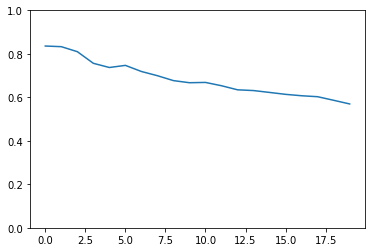

In [18]:
plt.plot(test_accuracies)
plt.ylim(ymin=0, ymax=1)
plt.show()

In [19]:
print(np.mean(test_accuracies))

0.6836135228099518


In [ ]:
%store -r DB1_test_accuracies
plt.plot(test_accuracies, color='g')
plt.plot(DB1_test_accuracies, color='b')
plt.ylim(ymin=0, ymax=1)
plt.show()

In [ ]:
plt.hist(tuner.appended_task_list[-1].train.weights[0 : tuner.appended_task_list[-2].train.weights.shape[0]], bins='auto')

In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()